In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [100]:
import numpy as np
import pandas as pd

def generate_engine_data(
    throttle_start=70,
    throttle_end=100,
    duration_sec=60,
    step_sec=10,
    mode="step"
):
    # print("runs")
    """
    Generate synthetic engine data for ML model training.

    Parameters:
        throttle_start (int): Starting throttle position (0–100)
        throttle_end (int): Ending throttle position (0–100)
        duration_sec (int): Total simulation duration in seconds
        step_sec (int): Time resolution per step
        mode (str): 'step' or 'linear' throttle transition

    Returns:
        pd.DataFrame: Synthetic time-series engine data
    """
    time = np.arange(0, duration_sec + step_sec, step_sec)

    if mode == "step":
        throttle = np.full_like(time, throttle_end)
    elif mode == "linear":
        throttle = np.linspace(throttle_start, throttle_end, len(time))
    else:
        raise ValueError("Mode must be either 'step' or 'linear'")

    rpm = 3000 + (throttle - 70) * 30 + np.random.normal(0, 50, len(time))
    coolant_temp = 85 + (rpm - 3000) * 0.01 + np.random.normal(0, 1.5, len(time))
    pressure = 2.8 + (throttle / 100) * 1.0 + np.random.normal(0, 0.1, len(time))
    vibration = 0.2 + (rpm - 3000) * 0.00005 + np.random.normal(0, 0.01, len(time))

    # Clamp values to realistic bounds
    rpm = np.clip(rpm, 800, 8000)
    coolant_temp = np.clip(coolant_temp, 60, 130)
    pressure = np.clip(pressure, 1.0, 5.0)
    vibration = np.clip(vibration, 0.1, 1.0)

    return pd.DataFrame({
        "t": time,
        "throttle_pos": throttle,
        "rpm": rpm.astype(int),
        "coolant_temp": coolant_temp.round(1),
        "pressure": pressure.round(2),
        "vibration": vibration.round(3)
    })


In [101]:
import matplotlib.pyplot as plt

def visualize_engine_data(df, title="Synthetic Engine Data"):
    fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

    axs[0].plot(df["t"], df["throttle_pos"], marker='o', color='purple')
    axs[0].set_ylabel("Throttle (%)")
    axs[0].set_title(title)

    axs[1].plot(df["t"], df["rpm"], marker='o', color='blue')
    axs[1].set_ylabel("RPM")

    axs[2].plot(df["t"], df["coolant_temp"], marker='o', color='red')
    axs[2].set_ylabel("Coolant Temp (°C)")

    axs[3].plot(df["t"], df["pressure"], marker='o', color='green')
    axs[3].set_ylabel("Pressure (bar)")

    axs[4].plot(df["t"], df["vibration"], marker='o', color='orange')
    axs[4].set_ylabel("Vibration")
    axs[4].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


    t  throttle_pos   rpm  coolant_temp  pressure  vibration
0   0           100  3899          93.4      3.96      0.255
1  10           100  3826          92.0      3.69      0.242
2  20           100  3846          91.5      3.72      0.245
3  30           100  3833          94.9      3.78      0.242
4  40           100  3909          95.3      3.81      0.244


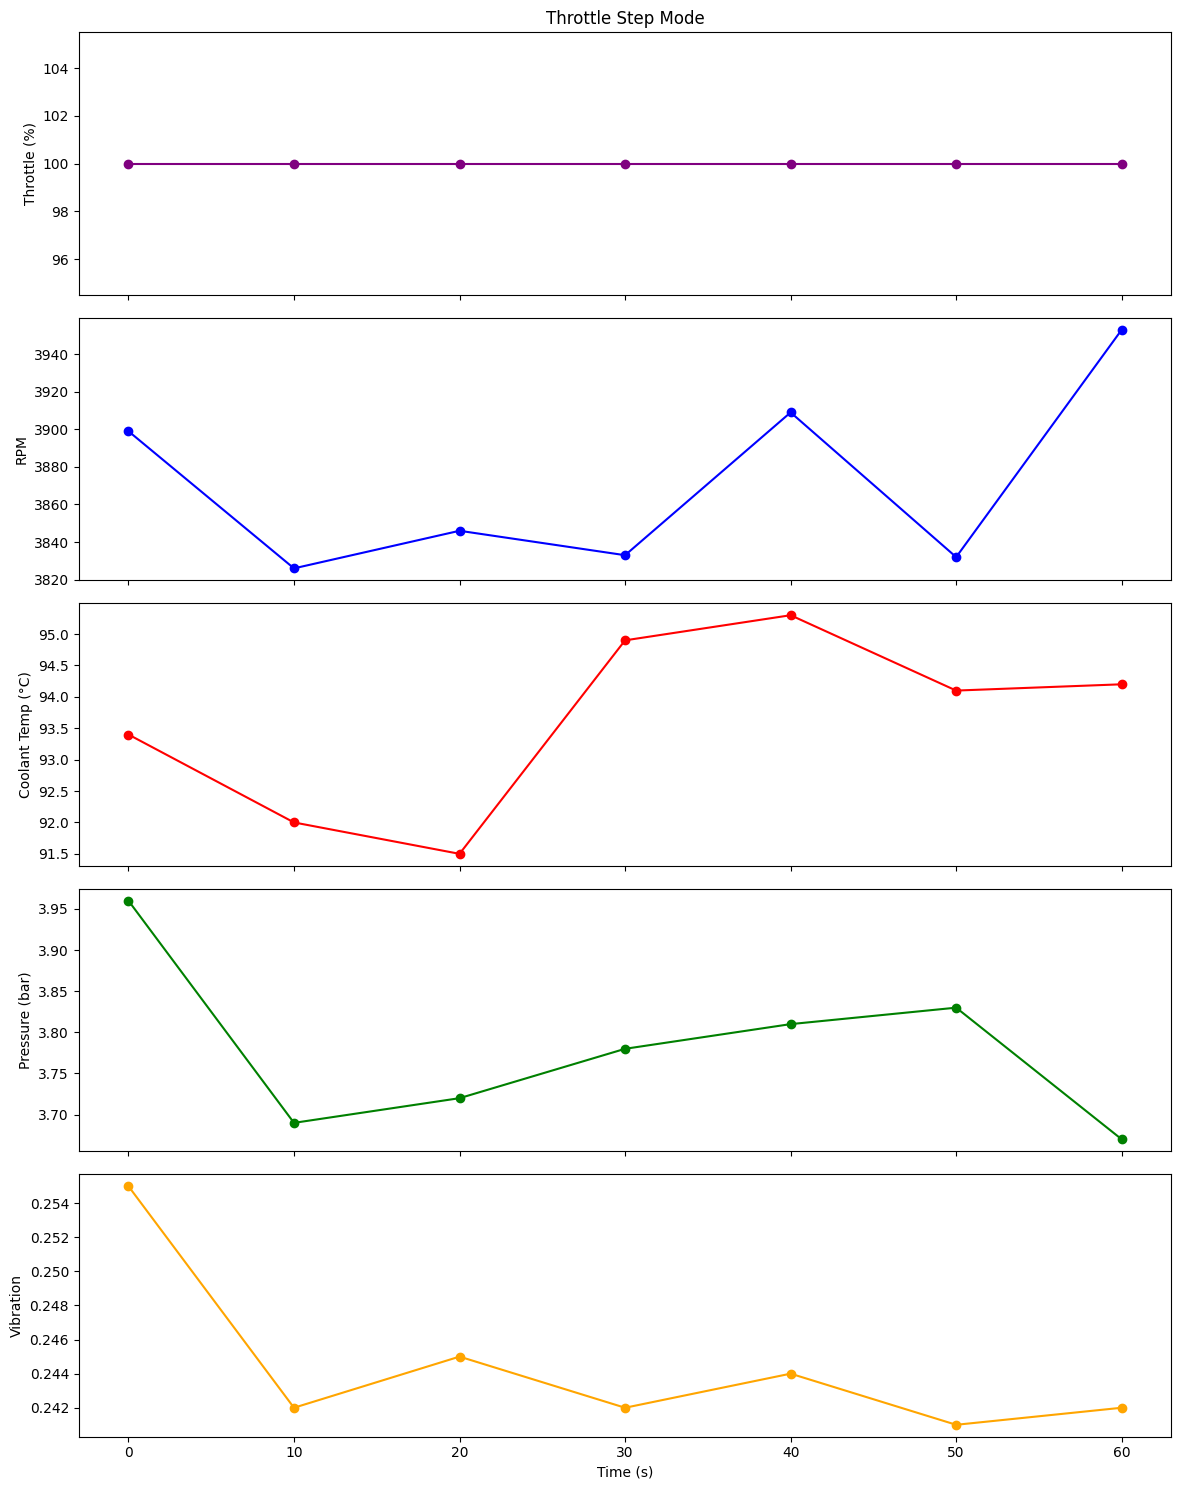

In [102]:
# %matplotlib inline

df_test = generate_engine_data(mode="step")
print(df_test.head())  # Debugging: check if data is generated

visualize_engine_data(df_test, title="Throttle Step Mode")


In [115]:
import numpy as np
import pandas as pd

def generate_24hr_engine_data_realistic_v2(seed=42):
    """
    Generate 24-hour synthetic engine data with improved realism:
    - Throttle has delayed effect on RPM (inertia)
    - RPM affects pressure, temperature with lag
    - Adds physical noise, resonance, ambient effects
    - Reduces artificial correlations
    """

    np.random.seed(seed)

    duration_min = 24 * 60
    step_sec = 30
    total_points = duration_min * 60 // step_sec  # 2880

    time = np.arange(0, total_points * step_sec, step_sec)

    # -- Phase pattern: idle, cruise, ramp, cooldown
    pattern = [0]*60 + [1]*100 + [2]*40 + [3]*40
    phases = (pattern * ((total_points // len(pattern)) + 1))[:total_points]

    # -- Throttle profile
    throttle = np.zeros(total_points)
    for i, phase in enumerate(phases):
        if phase == 0:  # idle
            throttle[i] = np.random.uniform(5, 20)
        elif phase == 1:  # cruise
            throttle[i] = np.random.uniform(35, 55)
        elif phase == 2:  # ramp
            throttle[i] = np.random.uniform(65, 100)
        elif phase == 3:  # cooldown
            throttle[i] = np.random.uniform(0, 10)

    # Smooth throttle transitions
    for i in range(1, total_points):
        max_delta = 10
        diff = throttle[i] - throttle[i-1]
        if abs(diff) > max_delta:
            throttle[i] = throttle[i-1] + np.sign(diff) * max_delta

    # -- Initialize arrays
    rpm = np.zeros(total_points)
    temp = np.zeros(total_points)
    pressure = np.zeros(total_points)
    vibration = np.zeros(total_points)

    # Initial conditions
    rpm[0] = 850
    temp[0] = 70
    pressure[0] = 1.6
    vibration[0] = 0.18

    for i in range(1, total_points):
        dt = step_sec

        # ===== RPM =====
        target_rpm = 800 + throttle[i]**1.05 * 2.2 + np.random.normal(0, 25)
        inertia = 0.3
        rpm[i] = rpm[i-1] + inertia * (target_rpm - rpm[i-1])
        rpm[i] = np.clip(rpm[i], 700, 6500)

        # ===== Temperature =====
        heat_from_rpm = (rpm[i] - 800) * 0.002
        heat_from_throttle = throttle[i] * 0.05
        ambient_cooling = 0.02 * (temp[i-1] - 20)
        temp[i] = temp[i-1] + 0.1 * (heat_from_rpm + heat_from_throttle - ambient_cooling)
        temp[i] += np.random.normal(0, 1.5)
        temp[i] = np.clip(temp[i], 60, 130)

        # ===== Pressure =====
        # Depends non-linearly on throttle and RPM
        base = 1.3 + (throttle[i]/100)**1.25 * 2.1 + (rpm[i] / 6000) * 0.8
        pressure[i] = pressure[i-1] + 0.25 * (base - pressure[i-1]) + np.random.normal(0, 0.05)
        pressure[i] = np.clip(pressure[i], 1.0, 4.2)

        # ===== Vibration =====
        base_vib = 0.14 + (rpm[i] / 6000) * 0.15
        throttle_spike = abs(throttle[i] - throttle[i-1]) * 0.003
        resonance = 0
        if 2800 < rpm[i] < 3300:
            resonance += 0.025 * np.sin((rpm[i] - 3000) * 0.01)
        if 4700 < rpm[i] < 5100:
            resonance += 0.02 * np.sin((rpm[i] - 4900) * 0.02)
        vibration[i] = base_vib + throttle_spike + resonance + np.random.normal(0, 0.008)
        vibration[i] = np.clip(vibration[i], 0.12, 0.4)

    return pd.DataFrame({
        "t_sec": time,
        "throttle_pos": throttle.round(1),
        "rpm": rpm.astype(int),
        "coolant_temp": temp.round(1),
        "pressure": pressure.round(2),
        "vibration": vibration.round(3)
    })


In [131]:
df_24hr = generate_24hr_engine_data_realistic_v2()
print(df_24hr.head())
print(f"Total rows: {len(df_24hr)}")


   t_sec  throttle_pos  rpm  coolant_temp  pressure  vibration
0      0          10.6  850          70.0      1.60      0.180
1     30          19.3  856          69.4      1.49      0.189
2     60          16.0  854          70.0      1.59      0.163
3     90          14.0  854          71.7      1.50      0.170
4    120           7.3  839          71.6      1.51      0.177
Total rows: 2880


In [133]:
import matplotlib.pyplot as plt

def visualize_engine_data(df, title="Synthetic Engine Data (Realistic 24hr)"):
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    # Throttle
    axs[0].plot(df["t_sec"] / 60, df["throttle_pos"], color='purple', linewidth=1.2)
    axs[0].set_ylabel("Throttle (%)")
    axs[0].set_title(title)
    axs[0].grid(True)

    # RPM
    axs[1].plot(df["t_sec"] / 60, df["rpm"], color='blue', linewidth=1.2)
    axs[1].set_ylabel("RPM")
    axs[1].grid(True)

    # Coolant Temperature
    axs[2].plot(df["t_sec"] / 60, df["coolant_temp"], color='red', linewidth=1.2)
    axs[2].set_ylabel("Coolant Temp (°C)")
    axs[2].grid(True)

    # Pressure
    axs[3].plot(df["t_sec"] / 60, df["pressure"], color='green', linewidth=1.2)
    axs[3].set_ylabel("Pressure (bar)")
    axs[3].grid(True)

    # Vibration
    axs[4].plot(df["t_sec"] / 60, df["vibration"], color='orange', linewidth=1.2)
    axs[4].set_ylabel("Vibration")
    axs[4].set_xlabel("Time (minutes)")
    axs[4].grid(True)

    plt.tight_layout()
    plt.show()


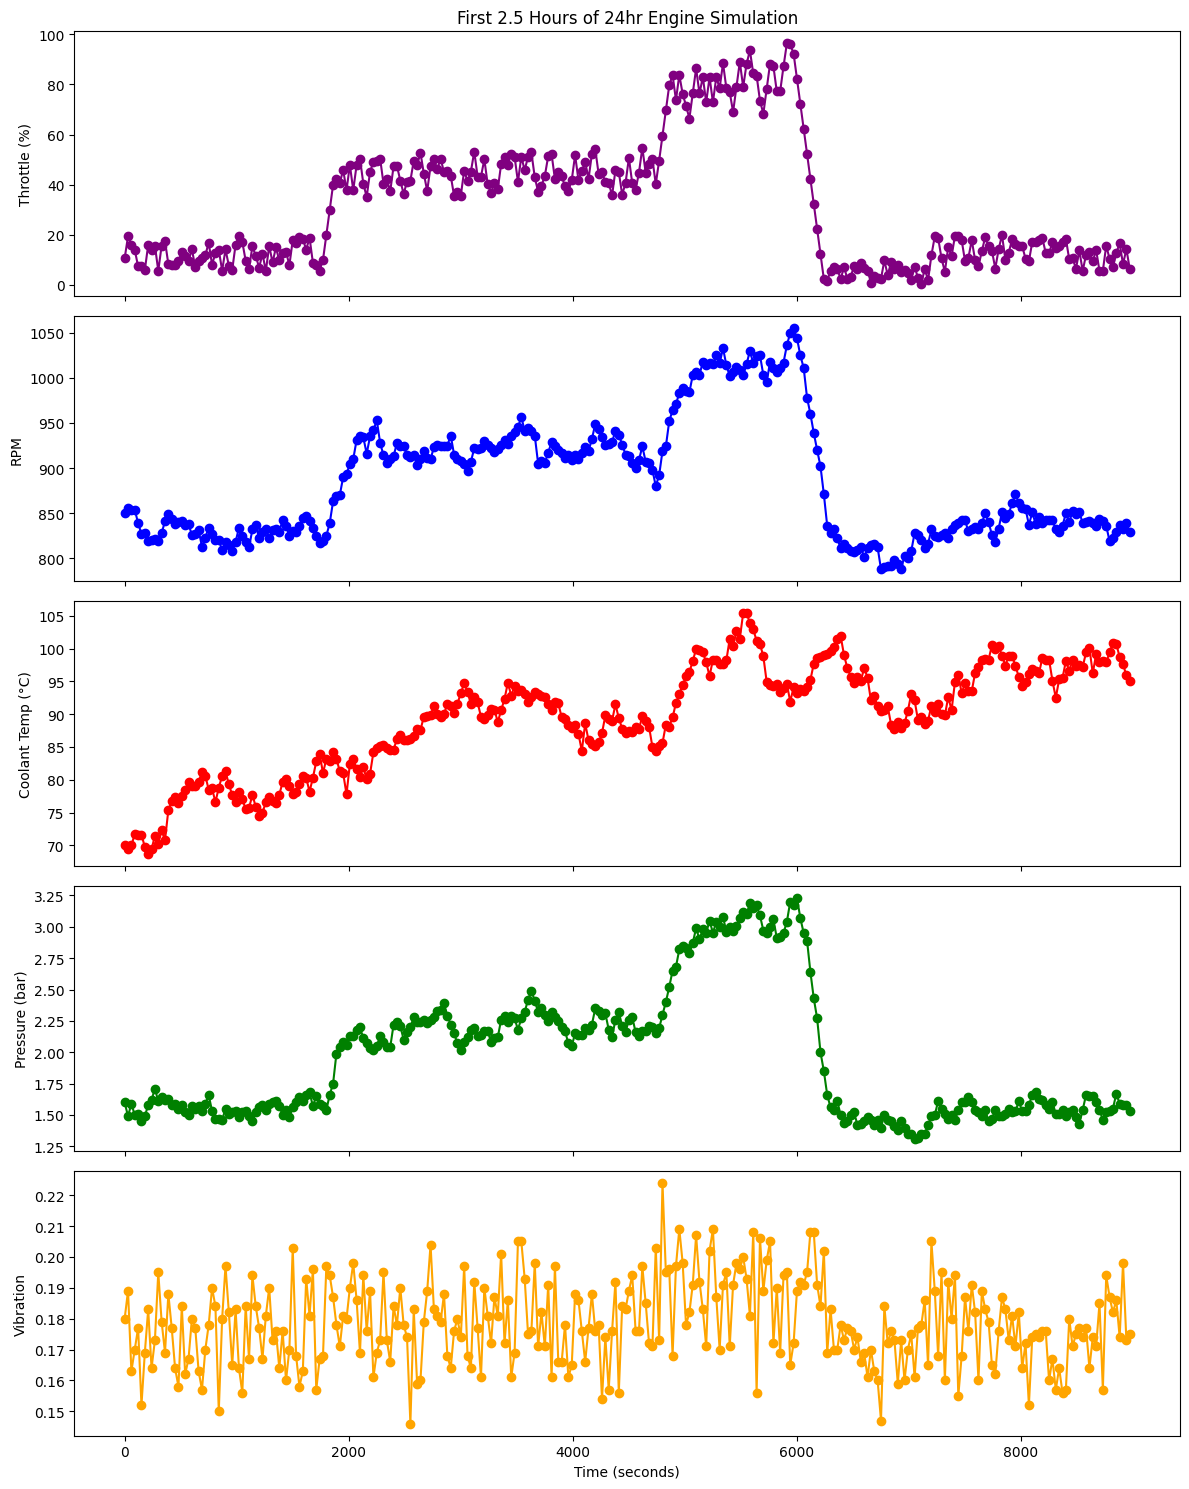

In [132]:
Visualize_engine_data(df_24hr.iloc[:300], title="First 2.5 Hours of 24hr Engine Simulation")


In [134]:
def create_supervised_dataset(df, window_size=3, input_features=None, target_features=None):
    if input_features is None:
        input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
    if target_features is None:
        target_features = ["rpm", "coolant_temp", "pressure", "vibration"]

    X, y = [], []

    for i in range(window_size, len(df)):
        input_window = []
        for j in range(i - window_size, i):
            input_window.extend(df.iloc[j][input_features].values.astype(float))
        target = df.iloc[i][target_features].values.astype(float)
        X.append(input_window)
        y.append(target)

    return np.array(X), np.array(y)


In [135]:
X, y = create_supervised_dataset(df_24hr)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [136]:
import joblib
joblib.dump(rf_model, "engine_forecast_rf_model.joblib")


['engine_forecast_rf_model.joblib']

In [137]:
def predict_next_state(history, model, override_throttle, input_features, target_features):
    """
    Predict next engine state based on history window and throttle override.

    Args:
        history: list of dicts (each dict = one timestep of features)
        model: trained ML model
        override_throttle: float, throttle value to inject at latest timestep
        input_features: list of strings (feature names per timestep)
        target_features: list of strings (what we're predicting)

    Returns:
        dict of predicted values, keyed by target feature
    """
    features = []

    for i, state in enumerate(history):
        step_features = state.copy()
        if i == len(history) - 1:
            step_features["throttle_pos"] = override_throttle  # inject throttle

        for feature in input_features:
            features.append(step_features[feature])

    pred = model.predict([features])[0]

    return {
        name: round(val, 3) if not isinstance(val, int) else int(val)
        for name, val in zip(target_features, pred)
    }


In [138]:
def test_throttle_influence(model, base_state, throttle_range, input_features, target_features, window_size=3):
    """
    Tests model's response to various throttle values using repeated history.

    Args:
        model: trained regression model
        base_state: dict of feature values from a single row (e.g. df_24hr.iloc[500].to_dict())
        throttle_range: list of throttle values to test
        input_features: list of input feature names used during training
        target_features: list of features being predicted
        window_size: number of historical timesteps (default = 3)

    Returns:
        pd.DataFrame showing predicted outputs for each throttle input
    """
    results = []

    for throttle in throttle_range:
        # Create artificial history with constant state and overridden throttle
        modified_window = [base_state.copy() for _ in range(window_size)]
        for step in modified_window:
            step["throttle_pos"] = throttle  # override all steps with consistent throttle

        # Predict using updated function
        pred = predict_next_state(
            history=modified_window,
            model=model,
            override_throttle=throttle,
            input_features=input_features,
            target_features=target_features
        )

        results.append({ "throttle_pos": throttle, **pred })

    return pd.DataFrame(results)


In [139]:
input_feats = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_feats = ["rpm", "coolant_temp", "pressure", "vibration"]

base_row = df_24hr.iloc[500].to_dict()

df_throttle_effect = test_throttle_influence(
    rf_model,
    base_row,
    [10, 30, 50, 70, 100],
    input_features=input_feats,
    target_features=target_feats,
    window_size=3
)

print(df_throttle_effect)



   throttle_pos     rpm  coolant_temp  pressure  vibration
0            10  831.59        61.768     1.570      0.178
1            30  857.33        62.378     1.748      0.184
2            50  882.90        63.039     1.928      0.177
3            70  937.40        71.330     2.322      0.186
4           100  939.07        71.730     2.345      0.187


In [140]:
print(df_24hr[['throttle_pos', 'rpm', 'coolant_temp', 'pressure']].corr())

              throttle_pos       rpm  coolant_temp  pressure
throttle_pos      1.000000  0.964939      0.065278  0.954583
rpm               0.964939  1.000000      0.091491  0.975056
coolant_temp      0.065278  0.091491      1.000000  0.113131
pressure          0.954583  0.975056      0.113131  1.000000


In [141]:
history_df = df_24hr.iloc[100:103]
history_window = history_df.to_dict(orient="records")
print(history_df)


     t_sec  throttle_pos  rpm  coolant_temp  pressure  vibration
100   3000          35.6  908          93.2      2.02      0.174
101   3030          45.6  904          94.7      2.08      0.197
102   3060          41.3  897          93.4      2.12      0.168


In [143]:
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]
override_throttle = 70  # or whatever value you want to simulate

next_state = predict_next_state(history_window, rf_model, override_throttle, input_features, target_features)
print("Predicted next state:")
print(next_state)


Predicted next state:
{'rpm': 903.6, 'coolant_temp': 90.488, 'pressure': 2.156, 'vibration': 0.176}


In [149]:
def simulate_engine(initial_window, model, throttle_override, steps, input_features, target_features):
    history = initial_window.copy()
    results = []

    for _ in range(steps):
        # Predict next state with updated throttle
        next_state = predict_next_state(
            history,
            model,
            override_throttle=throttle_override,
            input_features=input_features,
            target_features=target_features
        )

        # Build new row and append to results
        new_step = {
            "throttle_pos": throttle_override,
            **next_state
        }

        results.append(new_step)

        # Slide window
        history.pop(0)
        history.append(new_step)

    return pd.DataFrame(results)


In [151]:
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]

initial_window = df_24hr.iloc[300:303].to_dict(orient="records")
sim_results = simulate_engine(initial_window, rf_model, throttle_override=100, steps=120,
                              input_features=input_features, target_features=target_features)


In [152]:
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]

initial_window = df_24hr.iloc[300:303].to_dict(orient="records")
sim_results = simulate_engine(initial_window, rf_model, throttle_override=100, steps=120,
                              input_features=input_features, target_features=target_features)


In [156]:
import matplotlib.pyplot as plt

def plot_simulation(df_sim, title="Engine Simulation - Forecast Over Time"):
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    axs[0].plot(df_sim.index, df_sim["throttle_pos"], color="purple", marker='o')
    axs[0].set_ylabel("Throttle (%)")
    axs[0].set_title(title)

    axs[1].plot(df_sim.index, df_sim["rpm"], color="blue", marker='o')
    axs[1].set_ylabel("RPM")

    axs[2].plot(df_sim.index, df_sim["coolant_temp"], color="red", marker='o')
    axs[2].set_ylabel("Coolant Temp (°C)")

    axs[3].plot(df_sim.index, df_sim["pressure"], color="green", marker='o')
    axs[3].set_ylabel("Pressure (bar)")

    axs[4].plot(df_sim.index, df_sim["vibration"], color="orange", marker='o')
    axs[4].set_ylabel("Vibration")
    axs[4].set_xlabel("Simulation Steps")

    plt.tight_layout()
    plt.show()


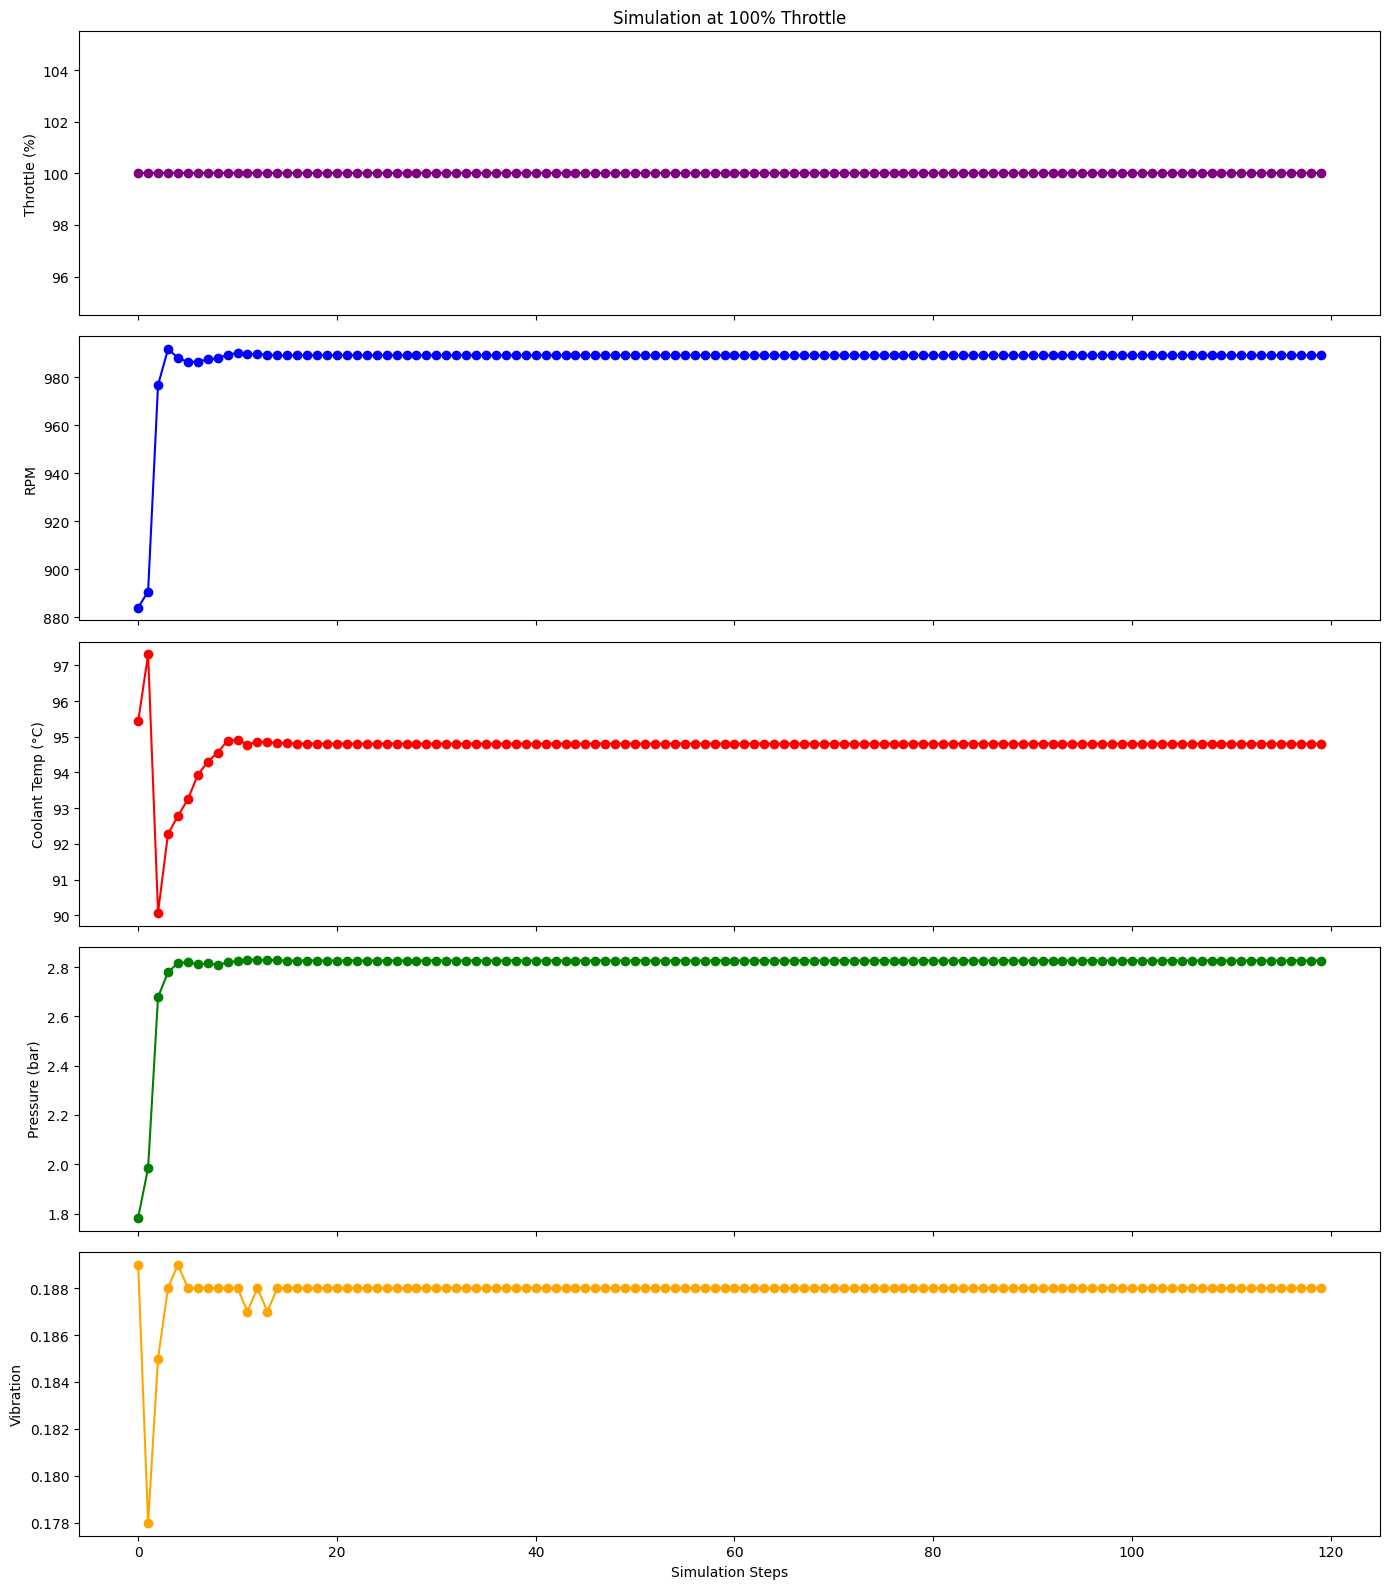

In [157]:
plot_simulation(sim_results, title="Simulation at 100% Throttle")

In [160]:
import matplotlib.pyplot as plt

def simulate_engine(initial_window, model, throttle_override, steps, input_features, target_features):
    """
    Simulate future engine behavior using a model and initial window.
    
    throttle_override: can be a single value or a list of length = steps
    """
    history = initial_window.copy()
    results = []

    for step in range(steps):
        # Support dynamic or static throttle
        if isinstance(throttle_override, list):
            this_throttle = throttle_override[step]
        else:
            this_throttle = throttle_override

        # Predict next state
        next_state = predict_next_state(history, model, override_throttle=this_throttle,
                                        input_features=input_features, target_features=target_features)
        
        # Append prediction to results
        results.append({ "throttle_pos": this_throttle, **next_state })

        # Update history window
        next_record = { "throttle_pos": this_throttle, **next_state }
        history.pop(0)
        history.append(next_record)

    return pd.DataFrame(results)


In [161]:
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]

sim_results = simulate_engine(
    initial_window,
    rf_model,
    throttle_override=[10]*30 + [60]*30 + [100]*60,
    steps=120,
    input_features=input_features,
    target_features=target_features
)


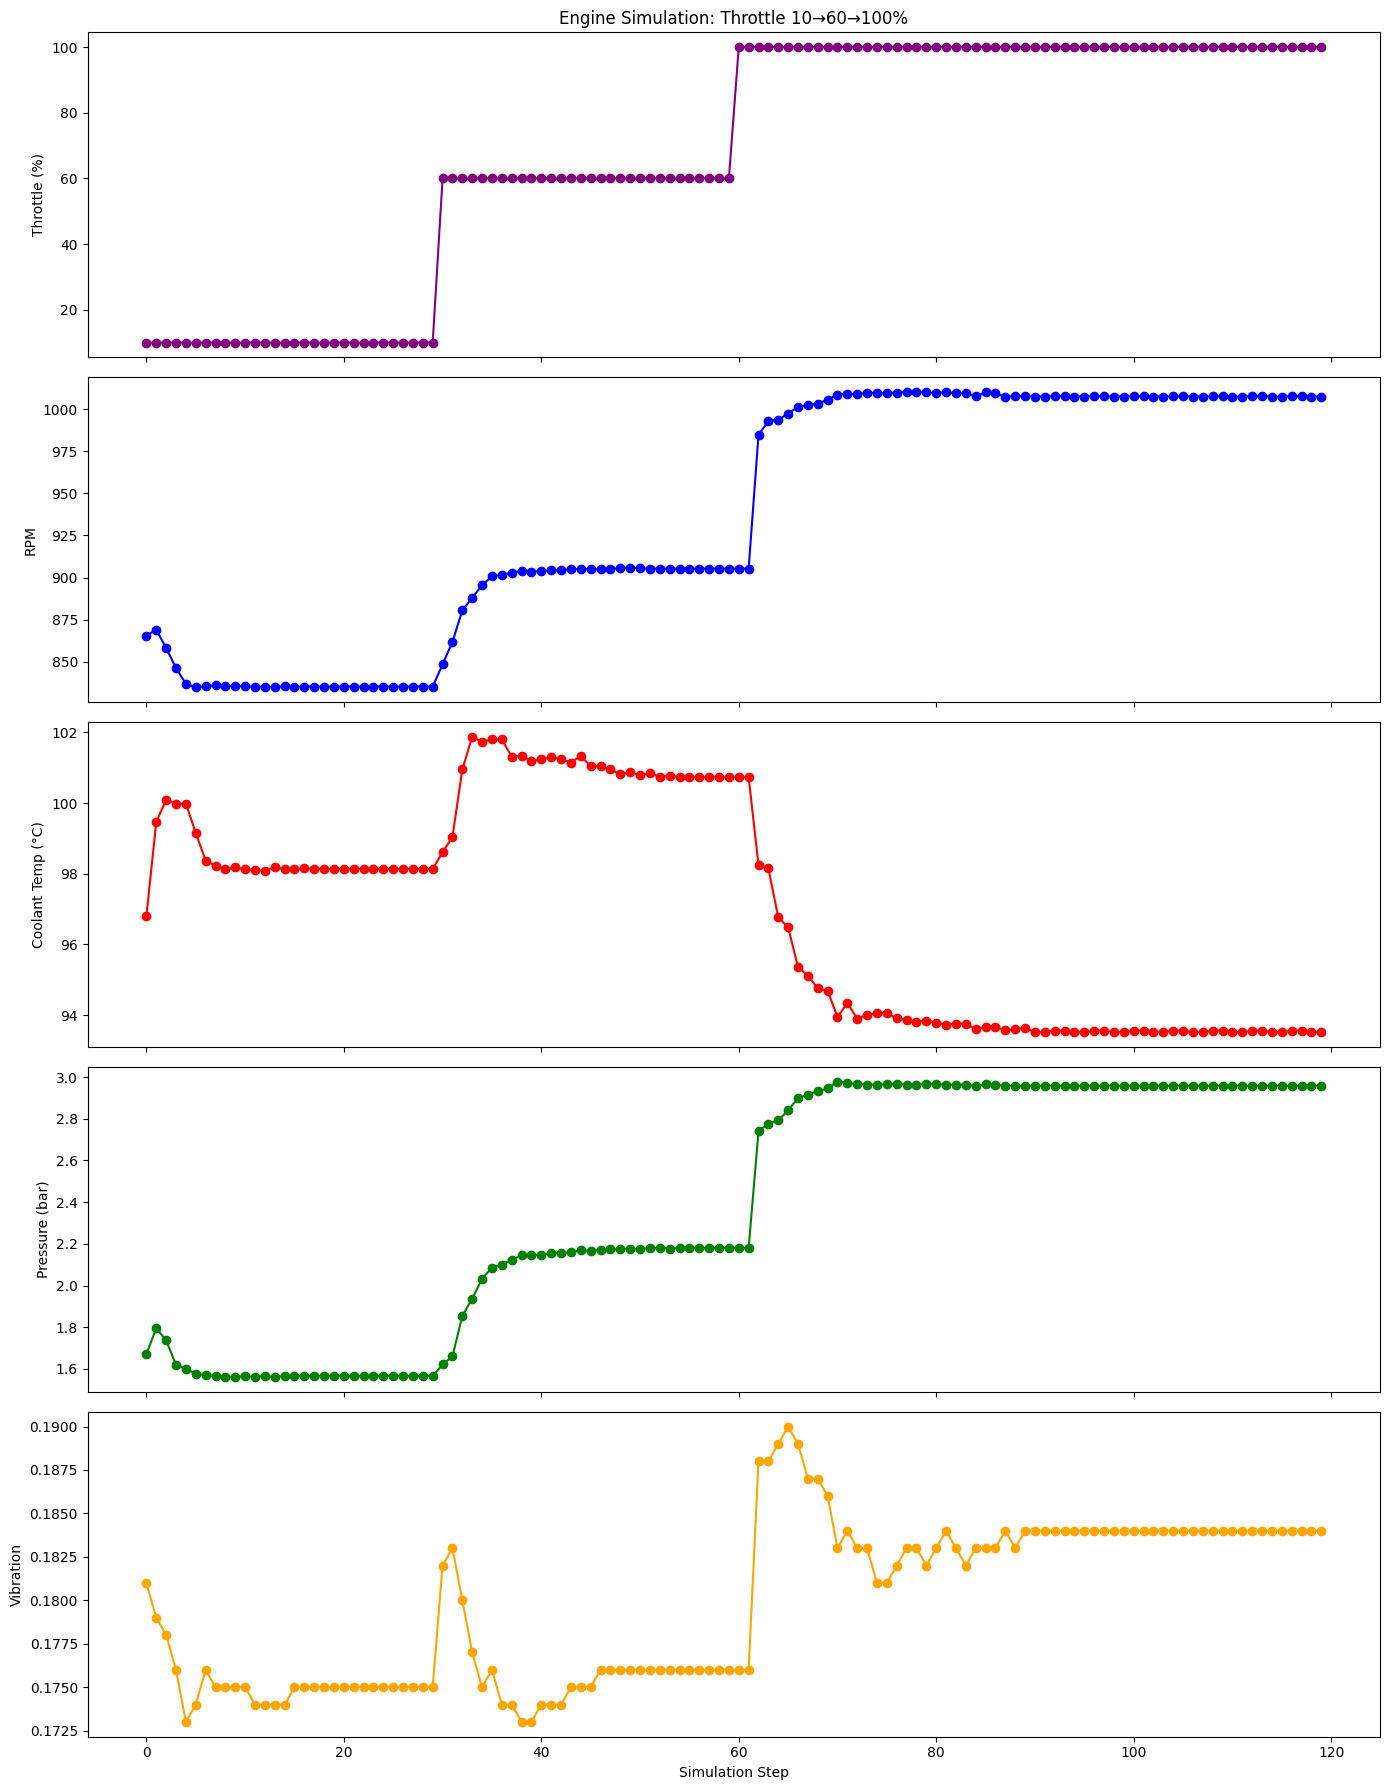

In [162]:
plot_simulation_dynamic(sim_results, title="Engine Simulation: Throttle 10→60→100%")